In [1]:
# !pip install ray[tune]
!pip install optuna==2.9.1
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 4.1 MB/s eta 0:00:00


In [15]:
import optuna
import shap
import numpy as np
import pandas as pd
import scipy.stats
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn import tree
import numpy as np
import pandas as pd
import sklearn
from functools import partial
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

the Simulation is borrowed from this blog https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%C2%A0insights.html


In [16]:
# This cell defines the functions we use to generate the data in our scenario
class FixableDataFrame(pd.DataFrame):
    """ Helper class for manipulating generative models.
    """
    def __init__(self, *args, fixed={}, **kwargs):
        self.__dict__["__fixed_var_dictionary"] = fixed
        super(FixableDataFrame, self).__init__(*args, **kwargs)
    def __setitem__(self, key, value):
        out = super(FixableDataFrame, self).__setitem__(key, value)
        if isinstance(key, str) and key in self.__dict__["__fixed_var_dictionary"]:
            out = super(FixableDataFrame, self).__setitem__(key, self.__dict__["__fixed_var_dictionary"][key])
        return out

# generate the data
def generator(n, fixed={}, seed=0):
    """ The generative model for our subscriber retention example.
    """
    if seed is not None:
        np.random.seed(seed)
    X = FixableDataFrame(fixed=fixed)

    # the number of sales calls made to this customer
    X["Sales calls"] = np.random.uniform(0, 4, size=(n,)).round()

    # the number of sales calls made to this customer
    X["Interactions"] = X["Sales calls"] + np.random.poisson(0.2, size=(n,))

    # the health of the regional economy this customer is a part of
    X["Economy"] = np.random.uniform(0, 1, size=(n,))

    # the time since the last product upgrade when this customer came up for renewal
    X["Last upgrade"] = np.random.uniform(0, 20, size=(n,))

    # how much the user perceives that they need the product
    X["Product need"] = (X["Sales calls"] * 0.1 + np.random.normal(0, 1, size=(n,)))

    # the fractional discount offered to this customer upon renewal
    X["Discount"] = ((1-scipy.special.expit(X["Product need"])) * 0.5 + 0.5 * np.random.uniform(0, 1, size=(n,))) / 2

    # What percent of the days in the last period was the user actively using the product
    X["Monthly usage"] = scipy.special.expit(X["Product need"] * 0.3 + np.random.normal(0, 1, size=(n,)))

    # how much ad money we spent per user targeted at this user (or a group this user is in)
    X["Ad spend"] = X["Monthly usage"] * np.random.uniform(0.99, 0.9, size=(n,)) + (X["Last upgrade"] < 1) + (X["Last upgrade"] < 2)

    # how many bugs did this user encounter in the since their last renewal
    X["Bugs faced"] = np.array([np.random.poisson(v*2) for v in X["Monthly usage"]])

    # how many bugs did the user report?
    X["Bugs reported"] = (X["Bugs faced"] * scipy.special.expit(X["Product need"])).round()

    # did the user renew?
    X["Did renew"] = scipy.special.expit(7 * (
          0.18 * X["Product need"] \
        + 0.08 * X["Monthly usage"] \
        + 0.1 * X["Economy"] \
        + 0.05 * X["Discount"] \
        + 0.05 * np.random.normal(0, 1, size=(n,)) \
        + 0.05 * (1 - X['Bugs faced'] / 20) \
        + 0.005 * X["Sales calls"] \
        + 0.015 * X["Interactions"] \
        + 0.1 / (X["Last upgrade"]/4 + 0.25)
        + X["Ad spend"] * 0.0 - 0.45
    ))

    # in real life we would make a random draw to get either 0 or 1 for if the
    # customer did or did not renew. but here we leave the label as the probability
    # so that we can get less noise in our plots. Uncomment this line to get
    # noiser causal effect lines but the same basic results
    X["Did renew"] = scipy.stats.bernoulli.rvs(X["Did renew"])

    return X

def user_retention_dataset():
    """ The observed data for model training.
    """
    n = 1000
    X_full = generator(n)
    y = X_full["Did renew"]
    X = X_full.drop(["Did renew", "Product need", "Bugs faced"], axis=1)
    return X, y

def fit_xgboost(X, y):
    """ Train an XGBoost model with early stopping.
    """
    X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(
        { "eta": 0.001, "subsample": 0.5, "max_depth": 2, "objective": "reg:logistic"}, dtrain, num_boost_round=200000,
        evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=False
    )
    return model

In [14]:
X, y = user_retention_dataset()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
def xgb_predict_model(mdl, data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=['Sales calls', 'Interactions', 'Economy', 'Last upgrade', 'Discount', 'Monthly usage', 'Ad spend', 'Bugs reported'])
    # return model.predict(data_asframe)
    return mdl.predict(xgb.DMatrix(data_asframe))

In [17]:
X_samp = shap.sample(X_train, 50)

In [18]:
 model2 = fit_xgboost(X, y)

With children, hence can be flipped

In [22]:
effect_coef = []
acc = []
def objective(trial):
    global configID
    (data, target) = X,y
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    explainerX = shap.sample(X, 100)
    shapvalsX = shap.sample(valid_x, 50)
    model_xgb_2 = partial(xgb_predict_model, bst)
    explainer = shap.KernelExplainer(model_xgb_2, explainerX)
    shap_values = explainer(shapvalsX)

    linearregression_model = LinearRegression()

    linearregression_model.fit(shapvalsX.loc[:,"Sales calls"].to_numpy().reshape(-1,1),shap_values.values[:,0].reshape(-1,1))
    y_samp = bst.predict(xgb.DMatrix(X_samp))
    effect_coef.append(linearregression_model.coef_[0,0])
    acc.append(accuracy)

    return linearregression_model.coef_[0,0], accuracy


In [25]:
study = optuna.create_study(directions=["minimize","maximize"])

[I 2023-10-20 16:26:51,810] A new study created in memory with name: no-name-5ea7c7df-84a1-4ac9-911d-9ee823f62e4a


In [26]:
study.optimize(objective, n_trials=100)
print(study.best_trial)

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:27:05,774] Trial 0 finished with values: [3.794147238186938e-05, 0.72] and parameters: {'booster': 'dart', 'lambda': 6.332069480679682e-08, 'alpha': 0.004565348040145082, 'subsample': 0.2801342386092115, 'colsample_bytree': 0.3831905250818761, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.0015377935243515081, 'gamma': 0.0002811203309089527, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0007186388558723309, 'skip_drop': 3.7116568511396746e-07}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:27:17,620] Trial 1 finished with values: [0.0001229951747473624, 0.688] and parameters: {'booster': 'dart', 'lambda': 2.665576227295836e-05, 'alpha': 0.003370572782422508, 'subsample': 0.5599471814774182, 'colsample_bytree': 0.3177620318658564, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.0032236468671478506, 'gamma': 0.0005573521127335229, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0026414231985032615, 'skip_drop': 0.001268701485651536}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:27:28,984] Trial 2 finished with values: [-0.0003273343388773007, 0.72] and parameters: {'booster': 'gbtree', 'lambda': 0.15071495061499293, 'alpha': 7.86547602818199e-08, 'subsample': 0.2076955511346153, 'colsample_bytree': 0.7399267299608574, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.009110582746120232, 'gamma': 1.6678841339105974e-05, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:27:40,117] Trial 3 finished with values: [0.0, 0.736] and parameters: {'booster': 'gbtree', 'lambda': 0.0005412595687110498, 'alpha': 9.626796742622902e-05, 'subsample': 0.8182594851585565, 'colsample_bytree': 0.7974356056957002, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.31643399216626916, 'gamma': 2.11594068430489e-05, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:27:51,025] Trial 4 finished with values: [0.0, 0.696] and parameters: {'booster': 'gbtree', 'lambda': 2.674257448988021e-06, 'alpha': 0.0004051323663212494, 'subsample': 0.26105531320587727, 'colsample_bytree': 0.7867466450456275, 'max_depth': 5, 'min_child_weight': 10, 'eta': 7.345281860667776e-07, 'gamma': 7.31226523020512e-07, 'grow_policy': 'depthwise'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:28:01,858] Trial 5 finished with values: [0.0, 0.7] and parameters: {'booster': 'dart', 'lambda': 0.21036828124258028, 'alpha': 4.586946799895436e-05, 'subsample': 0.2253703766043242, 'colsample_bytree': 0.3974199154895053, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.0016562605955324783, 'gamma': 7.203139264731406e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.855221384200372e-07, 'skip_drop': 4.503507028342179e-06}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:28:12,691] Trial 6 finished with values: [0.01800969506826778, 0.684] and parameters: {'booster': 'gbtree', 'lambda': 0.1259825407101318, 'alpha': 0.003862083208903417, 'subsample': 0.6377822537830411, 'colsample_bytree': 0.6397214790711598, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.2570025738197926, 'gamma': 0.1166760266092034, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:28:23,507] Trial 7 finished with values: [0.0, 0.668] and parameters: {'booster': 'gbtree', 'lambda': 1.011475850010655e-08, 'alpha': 0.787366872139246, 'subsample': 0.31170286743696507, 'colsample_bytree': 0.5785748062975028, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.08254005652362614, 'gamma': 4.286804799330266e-05, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:28:34,730] Trial 8 finished with values: [-0.0013551445833504669, 0.656] and parameters: {'booster': 'gbtree', 'lambda': 2.1477989726018356e-06, 'alpha': 0.17700152178728656, 'subsample': 0.8149325462356505, 'colsample_bytree': 0.43364338448774115, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.7279221310055586, 'gamma': 0.11395957889679166, 'grow_policy': 'depthwise'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:28:46,703] Trial 9 finished with values: [8.790374174813287e-10, 0.684] and parameters: {'booster': 'gbtree', 'lambda': 0.00030575410889892, 'alpha': 3.8328322575719216e-07, 'subsample': 0.5817049983963978, 'colsample_bytree': 0.5173636403438364, 'max_depth': 9, 'min_child_weight': 2, 'eta': 1.6551025717667526e-08, 'gamma': 0.00018176129572029453, 'grow_policy': 'depthwise'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:28:57,616] Trial 10 finished with values: [1.1562895216086385e-08, 0.688] and parameters: {'booster': 'gbtree', 'lambda': 0.6509098848643217, 'alpha': 0.029248720750527084, 'subsample': 0.8217683198238261, 'colsample_bytree': 0.6748618887656135, 'max_depth': 5, 'min_child_weight': 9, 'eta': 2.668035488340178e-07, 'gamma': 1.7839287209002892e-07, 'grow_policy': 'depthwise'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:29:07,586] Trial 11 finished with values: [3.667479713678548e-07, 0.704] and parameters: {'booster': 'gbtree', 'lambda': 4.789615255288376e-06, 'alpha': 0.05045869889014846, 'subsample': 0.4690322626907628, 'colsample_bytree': 0.40090555668294814, 'max_depth': 9, 'min_child_weight': 2, 'eta': 2.5896233641747524e-06, 'gamma': 1.9079323533690945e-05, 'grow_policy': 'depthwise'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:29:18,403] Trial 12 finished with values: [5.910559521215017e-05, 0.736] and parameters: {'booster': 'gbtree', 'lambda': 8.91929312821573e-06, 'alpha': 2.390077104099956e-06, 'subsample': 0.9801107197000032, 'colsample_bytree': 0.866290780257787, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.003980822996712718, 'gamma': 1.810554360522924e-07, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:29:30,564] Trial 13 finished with values: [0.0, 0.728] and parameters: {'booster': 'dart', 'lambda': 4.957323697130712e-07, 'alpha': 2.961780659281335e-07, 'subsample': 0.9783660193489598, 'colsample_bytree': 0.21410703047569185, 'max_depth': 3, 'min_child_weight': 9, 'eta': 1.5812474840289724e-06, 'gamma': 2.244415840839546e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.7823305102904165e-08, 'skip_drop': 9.278279302133083e-08}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:29:41,201] Trial 14 finished with values: [0.005715759117535793, 0.728] and parameters: {'booster': 'gblinear', 'lambda': 1.3829799394714665e-06, 'alpha': 0.029371652037463766, 'subsample': 0.880706225531318, 'colsample_bytree': 0.9688153267184769}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:29:52,746] Trial 15 finished with values: [0.00017599823250859535, 0.684] and parameters: {'booster': 'dart', 'lambda': 3.7954565399485845e-07, 'alpha': 3.378691537498166e-05, 'subsample': 0.9433706113910312, 'colsample_bytree': 0.8135995704992411, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.004202326530531681, 'gamma': 0.3042946075705487, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.5389893799130524e-08, 'skip_drop': 2.5429608169439027e-07}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:30:03,950] Trial 16 finished with values: [2.544896171522318e-05, 0.692] and parameters: {'booster': 'gbtree', 'lambda': 2.536780047223026e-06, 'alpha': 1.4263678962972897e-06, 'subsample': 0.6617561402703502, 'colsample_bytree': 0.43226339892900123, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.00039784935739261884, 'gamma': 2.6597810932911343e-05, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:30:13,594] Trial 17 finished with values: [1.4952178196022229e-05, 0.7] and parameters: {'booster': 'gbtree', 'lambda': 5.0434616353272143e-05, 'alpha': 0.0020627218749625087, 'subsample': 0.8926610496043299, 'colsample_bytree': 0.3087917475605207, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.0008035189143369848, 'gamma': 6.010281353466592e-05, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:30:24,739] Trial 18 finished with values: [0.01073329523866082, 0.652] and parameters: {'booster': 'gblinear', 'lambda': 0.0030880875228461533, 'alpha': 0.0026459854583781284, 'subsample': 0.7037974045340873, 'colsample_bytree': 0.44644469825793565}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:30:35,616] Trial 19 finished with values: [0.011387000875442753, 0.72] and parameters: {'booster': 'gblinear', 'lambda': 0.06287708647221839, 'alpha': 0.002278323575742072, 'subsample': 0.9397514868729748, 'colsample_bytree': 0.2336189089372489}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:30:46,653] Trial 20 finished with values: [0.00551379686851551, 0.704] and parameters: {'booster': 'gblinear', 'lambda': 2.04701427734545e-08, 'alpha': 0.00760813949994466, 'subsample': 0.2592523316087461, 'colsample_bytree': 0.9373491822343405}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:30:57,432] Trial 21 finished with values: [0.009891923358536212, 0.728] and parameters: {'booster': 'gblinear', 'lambda': 0.0026578607111515094, 'alpha': 1.740748592811753e-05, 'subsample': 0.9141957045784712, 'colsample_bytree': 0.710431524525404}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:31:07,629] Trial 22 finished with values: [0.00015963227768676314, 0.728] and parameters: {'booster': 'gbtree', 'lambda': 3.938175939521794e-05, 'alpha': 3.55926217313817e-07, 'subsample': 0.5011297749180719, 'colsample_bytree': 0.9632149501462364, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.004589074191194453, 'gamma': 2.699453251758771e-08, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:31:18,274] Trial 23 finished with values: [0.011515083192112535, 0.728] and parameters: {'booster': 'gblinear', 'lambda': 0.006612802697758755, 'alpha': 0.00045070069835685775, 'subsample': 0.7231619688756907, 'colsample_bytree': 0.993727638126396}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:31:29,322] Trial 24 finished with values: [4.04413678989782e-05, 0.74] and parameters: {'booster': 'gbtree', 'lambda': 7.65615319274378e-06, 'alpha': 1.53300123041837e-05, 'subsample': 0.8615312113238538, 'colsample_bytree': 0.675366377849951, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.0012359738067236278, 'gamma': 0.0014193687222034464, 'grow_policy': 'depthwise'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:31:40,367] Trial 25 finished with values: [0.003237897242944364, 0.704] and parameters: {'booster': 'gblinear', 'lambda': 5.134447353611034e-05, 'alpha': 0.001975422980189191, 'subsample': 0.7937708744385295, 'colsample_bytree': 0.6940420149579571}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:31:51,713] Trial 26 finished with values: [-0.0, 0.692] and parameters: {'booster': 'dart', 'lambda': 0.003375161802281161, 'alpha': 3.402967449145298e-08, 'subsample': 0.7012200783391898, 'colsample_bytree': 0.8984347506179529, 'max_depth': 9, 'min_child_weight': 7, 'eta': 1.0453571525854535e-06, 'gamma': 0.01831525834561176, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.002182717166100992, 'skip_drop': 0.001218039172410573}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:32:01,726] Trial 27 finished with values: [-0.004092747164781611, 0.732] and parameters: {'booster': 'gblinear', 'lambda': 9.532888403679202e-05, 'alpha': 6.871956837560959e-07, 'subsample': 0.26077192714224023, 'colsample_bytree': 0.5728701225080732}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:32:11,627] Trial 28 finished with values: [0.0028263067330582597, 0.72] and parameters: {'booster': 'gblinear', 'lambda': 2.204498662021347e-06, 'alpha': 5.942156714150402e-07, 'subsample': 0.7590819840504506, 'colsample_bytree': 0.29368055962671175}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:32:22,239] Trial 29 finished with values: [-0.0, 0.668] and parameters: {'booster': 'gbtree', 'lambda': 0.002010918744111624, 'alpha': 0.18223451924694806, 'subsample': 0.7961311327790106, 'colsample_bytree': 0.3832909179260748, 'max_depth': 3, 'min_child_weight': 7, 'eta': 1.957868714557934e-06, 'gamma': 1.131449428319835e-07, 'grow_policy': 'depthwise'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:32:32,973] Trial 30 finished with values: [0.014057719935836262, 0.708] and parameters: {'booster': 'gblinear', 'lambda': 0.029882774821121172, 'alpha': 5.000925134026763e-05, 'subsample': 0.6632895659442051, 'colsample_bytree': 0.25757272134345577}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:32:43,770] Trial 31 finished with values: [-0.004049009886603939, 0.736] and parameters: {'booster': 'gblinear', 'lambda': 9.821632778557171e-06, 'alpha': 2.104178705055992e-08, 'subsample': 0.5686797294169605, 'colsample_bytree': 0.5794099239572841}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:32:53,249] Trial 32 finished with values: [-4.368406638921033e-06, 0.708] and parameters: {'booster': 'gbtree', 'lambda': 1.2309575725467124e-05, 'alpha': 0.002082833764958874, 'subsample': 0.9217148388561021, 'colsample_bytree': 0.7026093419103978, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.0006018643214675713, 'gamma': 0.00033655900911455243, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:33:04,457] Trial 33 finished with values: [2.8511604781476866e-08, 0.728] and parameters: {'booster': 'dart', 'lambda': 0.0012057071041909947, 'alpha': 3.1654952684425694e-06, 'subsample': 0.3799126955410139, 'colsample_bytree': 0.6047136284369246, 'max_depth': 5, 'min_child_weight': 6, 'eta': 4.537060992248642e-07, 'gamma': 0.04630229922517052, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.039662696754833235, 'skip_drop': 4.941931434293924e-08}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:33:15,160] Trial 34 finished with values: [0.006581837862973264, 0.748] and parameters: {'booster': 'gblinear', 'lambda': 0.02430177741425148, 'alpha': 1.850637162469254e-07, 'subsample': 0.30186578075585385, 'colsample_bytree': 0.7538992012820185}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:33:27,007] Trial 35 finished with values: [2.4923529708036994e-07, 0.748] and parameters: {'booster': 'dart', 'lambda': 0.05939010504106321, 'alpha': 0.0011169280359510912, 'subsample': 0.9219168171303929, 'colsample_bytree': 0.9871400833995829, 'max_depth': 5, 'min_child_weight': 8, 'eta': 3.1943581725037345e-05, 'gamma': 0.0028822395076336877, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.3491220885798368e-07, 'skip_drop': 0.00015496207402071179}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:33:38,217] Trial 36 finished with values: [0.004754359463497156, 0.748] and parameters: {'booster': 'gbtree', 'lambda': 0.7313149441946556, 'alpha': 2.8590323726410317e-08, 'subsample': 0.48794261304029524, 'colsample_bytree': 0.9575079050841802, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.4918963422173497, 'gamma': 0.7520067761339652, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:33:48,581] Trial 37 finished with values: [-0.000977740431894575, 0.776] and parameters: {'booster': 'gblinear', 'lambda': 5.0602656934882793e-08, 'alpha': 7.583553968185685e-08, 'subsample': 0.3559826488169795, 'colsample_bytree': 0.5029472628923775}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:33:59,388] Trial 38 finished with values: [5.167818005216905e-08, 0.716] and parameters: {'booster': 'dart', 'lambda': 0.01835373290580182, 'alpha': 0.3543234288639053, 'subsample': 0.4238492274526385, 'colsample_bytree': 0.2861660258528182, 'max_depth': 5, 'min_child_weight': 6, 'eta': 2.5100546436737163e-06, 'gamma': 0.9321677169317368, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.7971487696935118e-08, 'skip_drop': 2.7386843434508836e-08}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:34:10,841] Trial 39 finished with values: [0.0, 0.688] and parameters: {'booster': 'dart', 'lambda': 0.026209854469813526, 'alpha': 8.690660783308748e-08, 'subsample': 0.7485126014657195, 'colsample_bytree': 0.3481631799642602, 'max_depth': 3, 'min_child_weight': 7, 'eta': 1.922238213540812e-08, 'gamma': 1.277868497638711e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.2559113527673217e-08, 'skip_drop': 3.477043966410589e-08}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:34:23,047] Trial 40 finished with values: [5.574873153339145e-07, 0.708] and parameters: {'booster': 'dart', 'lambda': 0.24926830245507522, 'alpha': 0.00039974196051671495, 'subsample': 0.6165827429681576, 'colsample_bytree': 0.9403319195091326, 'max_depth': 7, 'min_child_weight': 4, 'eta': 2.461972503304124e-05, 'gamma': 0.3260886217289434, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.7344480634614845, 'skip_drop': 7.364442188358242e-05}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:34:33,829] Trial 41 finished with values: [-0.0, 0.692] and parameters: {'booster': 'gblinear', 'lambda': 1.321751577778933e-05, 'alpha': 0.6343378620609762, 'subsample': 0.30134697684138817, 'colsample_bytree': 0.5016765718898104}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:34:45,585] Trial 42 finished with values: [0.002121399999827826, 0.716] and parameters: {'booster': 'dart', 'lambda': 0.024642836985310033, 'alpha': 1.4556728046935411e-05, 'subsample': 0.5828772998280389, 'colsample_bytree': 0.5638930059890626, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.01752795084849965, 'gamma': 0.002028107355140765, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.010580543004468732, 'skip_drop': 0.909138155438237}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:34:56,634] Trial 43 finished with values: [0.00026942793440442084, 0.736] and parameters: {'booster': 'gbtree', 'lambda': 1.7686047970835221e-07, 'alpha': 0.0022559594172976327, 'subsample': 0.7457560501366107, 'colsample_bytree': 0.6772471889450844, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.014485048219581468, 'gamma': 2.563720765548872e-07, 'grow_policy': 'depthwise'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

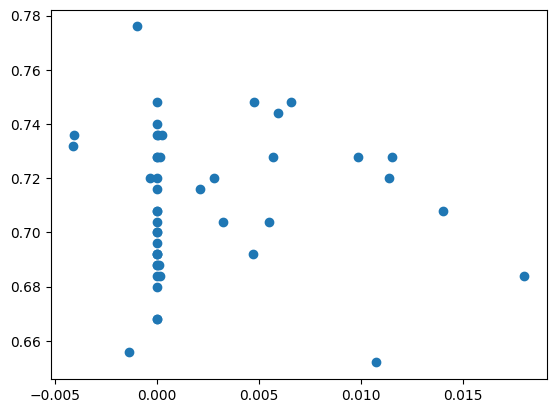

In [27]:
plt.scatter(effect_coef,acc)

In [28]:
effect_coef = []
acc = []
def objective(trial):
    global configID
    (data, target) = X,y
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    explainerX = shap.sample(X, 100)
    shapvalsX = shap.sample(valid_x, 50)
    model_xgb_2 = partial(xgb_predict_model, bst)
    explainer = shap.KernelExplainer(model_xgb_2, explainerX)
    shap_values = explainer(shapvalsX)

    linearregression_model = LinearRegression()

    linearregression_model.fit(shapvalsX.loc[:,"Last upgrade"].to_numpy().reshape(-1,1),shap_values.values[:,0].reshape(-1,1))
    y_samp = bst.predict(xgb.DMatrix(X_samp))
    effect_coef.append(linearregression_model.coef_[0,0])
    acc.append(accuracy)

    return linearregression_model.coef_[0,0], accuracy


In [30]:
study = optuna.create_study(directions=["maximize","maximize"])

[I 2023-10-20 16:40:06,307] A new study created in memory with name: no-name-781dcd68-ea97-429e-98e7-507e1dc87256


In [31]:
study.optimize(objective, n_trials=100)
print(study.best_trial)

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:40:20,483] Trial 0 finished with values: [-4.133220872696624e-05, 0.744] and parameters: {'booster': 'gblinear', 'lambda': 1.2566375817206629e-05, 'alpha': 0.003242183346002465, 'subsample': 0.6084358089981465, 'colsample_bytree': 0.5329686382200314}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:40:31,320] Trial 1 finished with values: [0.0005339694508280541, 0.7] and parameters: {'booster': 'dart', 'lambda': 0.0007107280121846834, 'alpha': 4.010840187852037e-08, 'subsample': 0.5579722076054394, 'colsample_bytree': 0.3355235210075833, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.13578253865861933, 'gamma': 3.2012909771341377e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.016552220124435923, 'skip_drop': 0.5691234261329992}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:40:41,968] Trial 2 finished with values: [-1.7939388169155058e-08, 0.732] and parameters: {'booster': 'gblinear', 'lambda': 0.015271594514658164, 'alpha': 0.029197709349512435, 'subsample': 0.6382750224847706, 'colsample_bytree': 0.8169944962526163}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:40:53,353] Trial 3 finished with values: [0.0, 0.708] and parameters: {'booster': 'dart', 'lambda': 1.2971147808525633e-06, 'alpha': 0.046904190511387764, 'subsample': 0.9768538276225869, 'colsample_bytree': 0.8994267814075514, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.01740757834296498, 'gamma': 9.565817104824327e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 9.292684137756646e-06, 'skip_drop': 0.11449851903289403}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:41:04,278] Trial 4 finished with values: [1.037159073207469e-09, 0.768] and parameters: {'booster': 'gbtree', 'lambda': 0.00023746844385631445, 'alpha': 7.005523941967661e-06, 'subsample': 0.33939684121991515, 'colsample_bytree': 0.49923335736162766, 'max_depth': 5, 'min_child_weight': 5, 'eta': 5.667898327257877e-07, 'gamma': 0.5305465188727311, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:41:14,110] Trial 5 finished with values: [-1.0369209669891147e-10, 0.76] and parameters: {'booster': 'gbtree', 'lambda': 0.35653438146118005, 'alpha': 0.005383391269106127, 'subsample': 0.4129467151980415, 'colsample_bytree': 0.4673326919667049, 'max_depth': 7, 'min_child_weight': 10, 'eta': 3.7845541799004316e-08, 'gamma': 2.7637813441123998e-08, 'grow_policy': 'depthwise'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:41:24,228] Trial 6 finished with values: [-0.00010862176011187264, 0.76] and parameters: {'booster': 'gblinear', 'lambda': 8.698119540882871e-07, 'alpha': 5.7990656840756455e-08, 'subsample': 0.41203648597047443, 'colsample_bytree': 0.2529701815028784}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:41:35,990] Trial 7 finished with values: [-3.650802619958925e-08, 0.716] and parameters: {'booster': 'dart', 'lambda': 0.006021084966462189, 'alpha': 0.00023918809601503722, 'subsample': 0.4160754465144678, 'colsample_bytree': 0.9201934490194441, 'max_depth': 3, 'min_child_weight': 8, 'eta': 9.027505171189778e-06, 'gamma': 3.5148718275662777e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.3348897216387687e-06, 'skip_drop': 9.338336292970562e-06}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:41:47,443] Trial 8 finished with values: [1.4622986164932208e-08, 0.7] and parameters: {'booster': 'dart', 'lambda': 3.221431888613288e-06, 'alpha': 9.728728800304897e-05, 'subsample': 0.8099871005625106, 'colsample_bytree': 0.37415543072765856, 'max_depth': 5, 'min_child_weight': 7, 'eta': 2.1751423826589068e-05, 'gamma': 5.610525222481617e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.3539180685246694, 'skip_drop': 2.2192567492848648e-08}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:41:59,765] Trial 9 finished with values: [-3.7216852393421917e-09, 0.756] and parameters: {'booster': 'dart', 'lambda': 1.6977668328281304e-05, 'alpha': 0.0004958987470560556, 'subsample': 0.9743631190386475, 'colsample_bytree': 0.6326713105334162, 'max_depth': 5, 'min_child_weight': 7, 'eta': 6.676208416476595e-06, 'gamma': 4.4050746966468266e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.2407934816454118e-08, 'skip_drop': 3.781424097913872e-05}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:42:11,329] Trial 10 finished with values: [-1.1020478986123375e-07, 0.728] and parameters: {'booster': 'dart', 'lambda': 0.010800653442253819, 'alpha': 3.3400115518794865e-06, 'subsample': 0.7676267416879801, 'colsample_bytree': 0.33101930232676235, 'max_depth': 7, 'min_child_weight': 10, 'eta': 5.5657738183458566e-05, 'gamma': 0.00029724776538424063, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.013229797851677372, 'skip_drop': 0.19443264804499602}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:42:21,762] Trial 11 finished with values: [0.00016402905651887698, 0.756] and parameters: {'booster': 'gblinear', 'lambda': 1.5100066628468163e-07, 'alpha': 8.754551741959689e-08, 'subsample': 0.22811578063300414, 'colsample_bytree': 0.511966995130825}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:42:31,746] Trial 12 finished with values: [-0.0003487134223887023, 0.704] and parameters: {'booster': 'gbtree', 'lambda': 4.152825586239017e-06, 'alpha': 1.7970345522446658e-07, 'subsample': 0.5427455267455759, 'colsample_bytree': 0.31502166519894914, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.5020317475865446, 'gamma': 0.4139623211456636, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

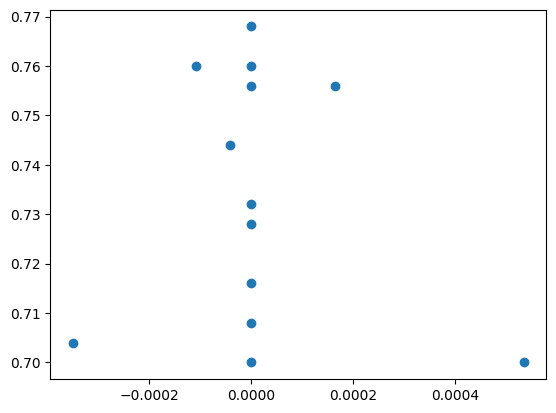

In [32]:
plt.scatter(effect_coef,acc)

No children, hence can't flip

In [33]:
effect_coef = []
acc = []
def objective(trial):
    global configID
    (data, target) = X,y
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    explainerX = shap.sample(X, 100)
    shapvalsX = shap.sample(valid_x, 50)
    model_xgb_2 = partial(xgb_predict_model, bst)
    explainer = shap.KernelExplainer(model_xgb_2, explainerX)
    shap_values = explainer(shapvalsX)

    linearregression_model = LinearRegression()

    linearregression_model.fit(shapvalsX.loc[:,"Interactions"].to_numpy().reshape(-1,1),shap_values.values[:,0].reshape(-1,1))
    y_samp = bst.predict(xgb.DMatrix(X_samp))
    effect_coef.append(linearregression_model.coef_[0,0])
    acc.append(accuracy)

    return linearregression_model.coef_[0,0], accuracy


In [34]:
study = optuna.create_study(directions=["minimize","maximize"])

[I 2023-10-20 16:44:03,973] A new study created in memory with name: no-name-e9e20f10-4ecf-49e1-a33d-6bad1439b0f4


In [35]:
study.optimize(objective, n_trials=100)
print(study.best_trial)

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:44:29,101] Trial 0 finished with values: [0.00406562079539841, 0.736] and parameters: {'booster': 'dart', 'lambda': 0.6546554033284621, 'alpha': 0.0027276218570356954, 'subsample': 0.9753302962312171, 'colsample_bytree': 0.7319888611272203, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.24487464511113094, 'gamma': 4.79522634128354e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.514898991387919e-06, 'skip_drop': 2.694042167351185e-08}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:44:39,811] Trial 1 finished with values: [0.00066231657834357, 0.716] and parameters: {'booster': 'gbtree', 'lambda': 2.6210458875563716e-07, 'alpha': 1.4475816544643937e-05, 'subsample': 0.34147004343625326, 'colsample_bytree': 0.6907763629016963, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.009147459428097195, 'gamma': 0.0004987754302113865, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:44:50,371] Trial 2 finished with values: [0.001867037655896047, 0.72] and parameters: {'booster': 'dart', 'lambda': 0.00018540866486531327, 'alpha': 4.3424279728518983e-05, 'subsample': 0.2750305878218964, 'colsample_bytree': 0.7681349556598436, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.33455633088618625, 'gamma': 1.5699338852342572e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.1644172465009372, 'skip_drop': 2.0927188071201453e-06}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:45:01,204] Trial 3 finished with values: [0.0047218120957198675, 0.736] and parameters: {'booster': 'gblinear', 'lambda': 6.157123543130551e-07, 'alpha': 0.014229614266418288, 'subsample': 0.34581697409362133, 'colsample_bytree': 0.4514116350011321}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:45:12,918] Trial 4 finished with values: [1.6132396936156707e-07, 0.676] and parameters: {'booster': 'dart', 'lambda': 3.5392858732024097e-08, 'alpha': 1.2360058978292096e-05, 'subsample': 0.27197860247889233, 'colsample_bytree': 0.536669872582868, 'max_depth': 9, 'min_child_weight': 9, 'eta': 4.101694612448568e-06, 'gamma': 0.12744448804215358, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.4023284064225096e-06, 'skip_drop': 4.0683237568542675e-05}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:45:23,710] Trial 5 finished with values: [0.005515527998812225, 0.712] and parameters: {'booster': 'gblinear', 'lambda': 5.65529659893906e-05, 'alpha': 1.5329969395363605e-08, 'subsample': 0.48355430957873546, 'colsample_bytree': 0.7391168592616102}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:45:35,218] Trial 6 finished with values: [9.730106403630513e-10, 0.688] and parameters: {'booster': 'dart', 'lambda': 0.0004265118457174441, 'alpha': 0.0007266011608180379, 'subsample': 0.5877341369776077, 'colsample_bytree': 0.44732736834340514, 'max_depth': 5, 'min_child_weight': 8, 'eta': 3.140551684056615e-08, 'gamma': 0.003481162177868037, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.136407445809181e-08, 'skip_drop': 1.0345235536584328e-06}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:45:45,863] Trial 7 finished with values: [0.00017702589779518206, 0.736] and parameters: {'booster': 'gbtree', 'lambda': 4.732527150261363e-05, 'alpha': 0.0014659868941175995, 'subsample': 0.44186516207457216, 'colsample_bytree': 0.47973847263278185, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.010162000554641771, 'gamma': 0.016895361276165404, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:45:55,762] Trial 8 finished with values: [0.002905093523376969, 0.748] and parameters: {'booster': 'gblinear', 'lambda': 1.7055646492484144e-07, 'alpha': 2.234975931486462e-08, 'subsample': 0.5554901546397417, 'colsample_bytree': 0.7771674401732955}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:46:07,112] Trial 9 finished with values: [0.0002361774806039916, 0.756] and parameters: {'booster': 'dart', 'lambda': 0.022609919358476116, 'alpha': 0.00021317136886994857, 'subsample': 0.9945402944372772, 'colsample_bytree': 0.6279290649830007, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.003057822925826019, 'gamma': 1.095967238864335e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0633548465341138, 'skip_drop': 0.0014114375225045745}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:46:18,856] Trial 10 finished with values: [3.951222858885716e-06, 0.7] and parameters: {'booster': 'dart', 'lambda': 9.494484664250381e-08, 'alpha': 0.2102789940554931, 'subsample': 0.6806608249743269, 'colsample_bytree': 0.7092910324214925, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.00010620307541525298, 'gamma': 0.0002556352048951238, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.012462084932861326, 'skip_drop': 0.0004079597136074182}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:46:30,144] Trial 11 finished with values: [0.000277889947131253, 0.788] and parameters: {'booster': 'dart', 'lambda': 0.0053009150627623325, 'alpha': 0.4205004900295, 'subsample': 0.8458593460922839, 'colsample_bytree': 0.9858275580102254, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.13366743244383644, 'gamma': 7.492832744047026e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.001260223543410205, 'skip_drop': 0.00038989938795272813}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:46:41,519] Trial 12 finished with values: [0.008957062542553696, 0.708] and parameters: {'booster': 'gblinear', 'lambda': 0.03626934818697365, 'alpha': 2.0296922971265867e-07, 'subsample': 0.33629326407385773, 'colsample_bytree': 0.49010836560286136}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:46:53,286] Trial 13 finished with values: [6.460413647532e-07, 0.772] and parameters: {'booster': 'dart', 'lambda': 0.00012767433393129948, 'alpha': 1.804461473361649e-08, 'subsample': 0.527859436767671, 'colsample_bytree': 0.6660017151025723, 'max_depth': 9, 'min_child_weight': 8, 'eta': 1.564627224517256e-05, 'gamma': 5.021781638085894e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.597503195431255e-06, 'skip_drop': 0.00797293255243305}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:47:02,526] Trial 14 finished with values: [0.0005316562082212656, 0.72] and parameters: {'booster': 'gblinear', 'lambda': 5.23778948253074e-05, 'alpha': 0.00015256203631644163, 'subsample': 0.977956654363719, 'colsample_bytree': 0.45396812394984815}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:47:13,190] Trial 15 finished with values: [0.0, 0.664] and parameters: {'booster': 'gblinear', 'lambda': 2.1819445065115246e-06, 'alpha': 0.2270595686368661, 'subsample': 0.8587745752104212, 'colsample_bytree': 0.3383520650167413}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:47:24,461] Trial 16 finished with values: [7.235991343503076e-06, 0.728] and parameters: {'booster': 'gbtree', 'lambda': 1.079626404800397e-08, 'alpha': 0.9037594598540963, 'subsample': 0.8320986904748844, 'colsample_bytree': 0.23721016799408307, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.00015815927166238557, 'gamma': 0.0032219745878228016, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:47:36,471] Trial 17 finished with values: [8.859396796887e-08, 0.728] and parameters: {'booster': 'dart', 'lambda': 5.5128435450564466e-05, 'alpha': 0.012097192700726041, 'subsample': 0.5741535404375219, 'colsample_bytree': 0.9099636784886784, 'max_depth': 9, 'min_child_weight': 3, 'eta': 4.434588447872439e-06, 'gamma': 5.666792775757047e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.33769669569140676, 'skip_drop': 1.4246681547585752e-05}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:47:47,271] Trial 18 finished with values: [4.884820069695326e-07, 0.7] and parameters: {'booster': 'gbtree', 'lambda': 0.00027258205347479794, 'alpha': 6.348678015390291e-05, 'subsample': 0.31943790657367854, 'colsample_bytree': 0.625047961807836, 'max_depth': 7, 'min_child_weight': 6, 'eta': 7.077308204252031e-06, 'gamma': 0.028340165604110585, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:47:57,262] Trial 19 finished with values: [1.5366921629553446e-09, 0.72] and parameters: {'booster': 'gbtree', 'lambda': 0.05986119899477354, 'alpha': 0.000563956892103398, 'subsample': 0.2460230789871697, 'colsample_bytree': 0.9439322168937601, 'max_depth': 5, 'min_child_weight': 4, 'eta': 4.199952857597194e-08, 'gamma': 0.15430016231884902, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-20 16:48:08,051] Trial 20 finished with values: [6.278377129808847e-09, 0.676] and parameters: {'booster': 'gbtree', 'lambda': 0.0011257225320961263, 'alpha': 5.099523641892282e-08, 'subsample': 0.48200448935170626, 'colsample_bytree': 0.7549712824288437, 'max_depth': 7, 'min_child_weight': 3, 'eta': 2.661796911709957e-07, 'gamma': 0.00014225814769690248, 'grow_policy': 'lossguide'}. 


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

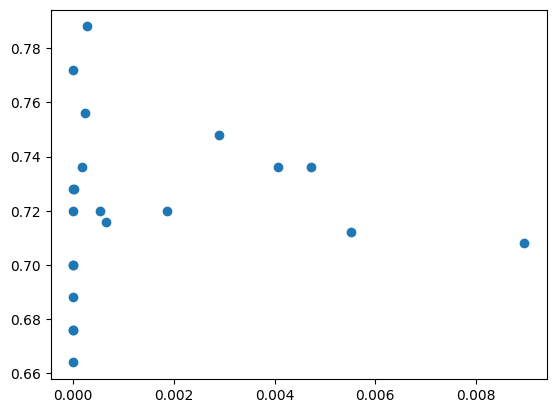

In [36]:
plt.scatter(effect_coef,acc)